<a href="https://colab.research.google.com/github/AimjGuytidy/WQU-Thesis/blob/main/NBEATS_ARIMA_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Darts NBEATS Model

In [ ]:
%pip install  --quiet darts

In [ ]:
%pip install --quiet -U xlrd

     |████████████████████████████████| 96 kB 2.5 MB/s 


In [ ]:
import pandas as pd
from darts import TimeSeries
import matplotlib.pyplot as plt
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import mape, r2_score
from darts.datasets import EnergyDataset

In [ ]:
def display_forecast(pred_series, ts_transformed, forecast_type, start_date=None):
    plt.figure(figsize=(8,5))
    if (start_date):
        ts_transformed = ts_transformed.drop_before(start_date)
    ts_transformed.univariate_component(0).plot(label='actual')
    pred_series.plot(label=('historic ' + forecast_type + ' forecasts'))
    plt.title('R2: {}'.format(r2_score(ts_transformed.univariate_component(0), pred_series)))
    plt.legend();

In [ ]:
time = pd.read_excel('/content/RWTCd.xls',sheet_name='Data 1',header=2,parse_dates=True)
time.head()

,Date,"Cushing, OK WTI Spot Price FOB (Dollars per Barrel)"
0,1986-01-02,25.56
1,1986-01-03,26.00
2,1986-01-06,26.53
3,1986-01-07,25.85
4,1986-01-08,25.87


In [ ]:
time.isna().sum()

Date                                                   0
Cushing, OK WTI Spot Price FOB (Dollars per Barrel)    0
dtype: int64

In [ ]:
time.describe()

,"Cushing, OK WTI Spot Price FOB (Dollars per Barrel)"
count,8987.000000
mean,44.388783
std,28.743869
min,-36.980000
25%,19.850000
50%,32.920000
75%,63.400000
max,145.310000


In [ ]:
time[time['Cushing, OK WTI Spot Price FOB (Dollars per Barrel)']==time['Cushing, OK WTI Spot Price FOB (Dollars per Barrel)'].min()]

,Date,"Cushing, OK WTI Spot Price FOB (Dollars per Barrel)"
8643,2020-04-20,-36.98


In [ ]:
import plotly.express as px

In [ ]:
px.line(time,x ='Date',
        y='Cushing, OK WTI Spot Price FOB (Dollars per Barrel)')

In [ ]:
time = time.rename(columns={'Cushing, OK WTI Spot Price FOB (Dollars per Barrel)':'cushing'})

In [ ]:
time.head(2)

,Date,cushing
0,1986-01-02,25.56
1,1986-01-03,26.00


In [ ]:
filler = MissingValuesFiller()
scaler = Scaler()
ts = scaler.fit_transform(
              TimeSeries.from_dataframe(
                          time, 'Date', 'cushing',freq='B'))            

In [ ]:
ts

<TimeSeries (DataArray) (Date: 9303, component: 1, sample: 1)>
array([[[0.34307971]],

       [[0.34549344]],

       [[0.3484009 ]],

       ...,

       [[0.57271381]],

       [[0.58050359]],

       [[0.58291733]]])
Coordinates:
  * Date       (Date) datetime64[ns] 1986-01-02 1986-01-03 ... 2021-08-30
  * component  (component) object 'cushing'
Dimensions without coordinates: sample

<AxesSubplot:xlabel='Date'>

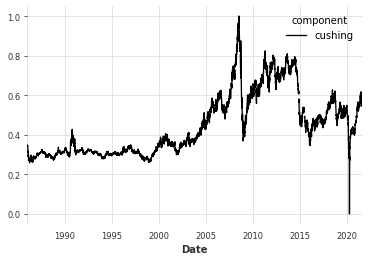

In [ ]:
ts.pd_dataframe().plot()

In [ ]:
ts.pd_dataframe().isna().sum()

component
cushing    316
dtype: int64

In [ ]:
filler = MissingValuesFiller()
scaler = Scaler()
ts_filled = scaler.fit_transform(
              filler.transform(TimeSeries.from_dataframe(
                          time, 'Date', 'cushing',freq='B'))) 

In [ ]:
ts_filled.pd_dataframe().isna().sum()

component
cushing    0
dtype: int64

<AxesSubplot:xlabel='Date'>

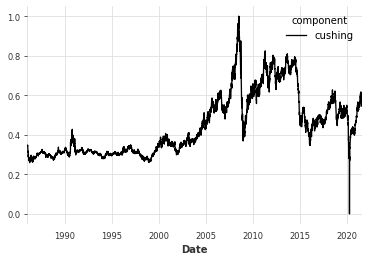

In [ ]:
ts_filled.pd_dataframe().plot()

In [ ]:
from datetime import datetime as dt
ts_filled.pd_dataframe()[ts_filled.pd_dataframe().index == dt(2005,1,2)]

component,cushing
Date,


In [ ]:
train1, val1 = ts_filled.split_after(pd.Timestamp('20050102'))

In [ ]:
ts_nbeats = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=7,
    generic_architecture=True,
    num_stacks=10,
    num_blocks=1,
    num_layers=4,
    layer_widths=512,
    n_epochs=100,
    nr_epochs_val_period=1,
    batch_size=800,
    model_name='nbeats_oil'
)

In [ ]:
ts_nbeats.fit(train1,val_series=val1)

[2021-10-07 08:36:37,331] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 4922 samples.
[2021-10-07 08:36:37,331] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 4922 samples.
[2021-10-07 08:36:37,417] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.
[2021-10-07 08:36:37,417] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.


In [ ]:
pred_series1 = ts_nbeats.historical_forecasts(
    ts_filled,
    start=pd.Timestamp('20050103'), 
    forecast_horizon=7,
    stride=5,
    retrain=False,
    verbose=True
)

100%|██████████| 868/868 [01:35<00:00,  9.09it/s]


In [ ]:
pred_series1

<TimeSeries (DataArray) (time: 868, component: 1, sample: 1)>
array([[[0.44006379]],

       [[0.45032091]],

       [[0.46263232]],

       [[0.4695051 ]],

       [[0.47116951]],

       [[0.46547932]],

       [[0.46079751]],

       [[0.46194066]],

       [[0.47813902]],

       [[0.48912679]],

...

       [[0.54004222]],

       [[0.54457265]],

       [[0.55309069]],

       [[0.55633094]],

       [[0.55373237]],

       [[0.54882357]],

       [[0.54253833]],

       [[0.54607366]],

       [[0.53521733]],

       [[0.53246917]]])
Coordinates:
  * time       (time) datetime64[ns] 2005-01-11 2005-01-18 ... 2021-08-24
  * component  (component) <U1 '0'
Dimensions without coordinates: sample

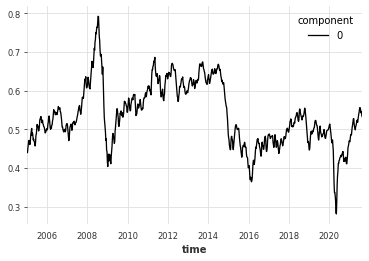

In [ ]:
pred_series1.pd_dataframe().plot();

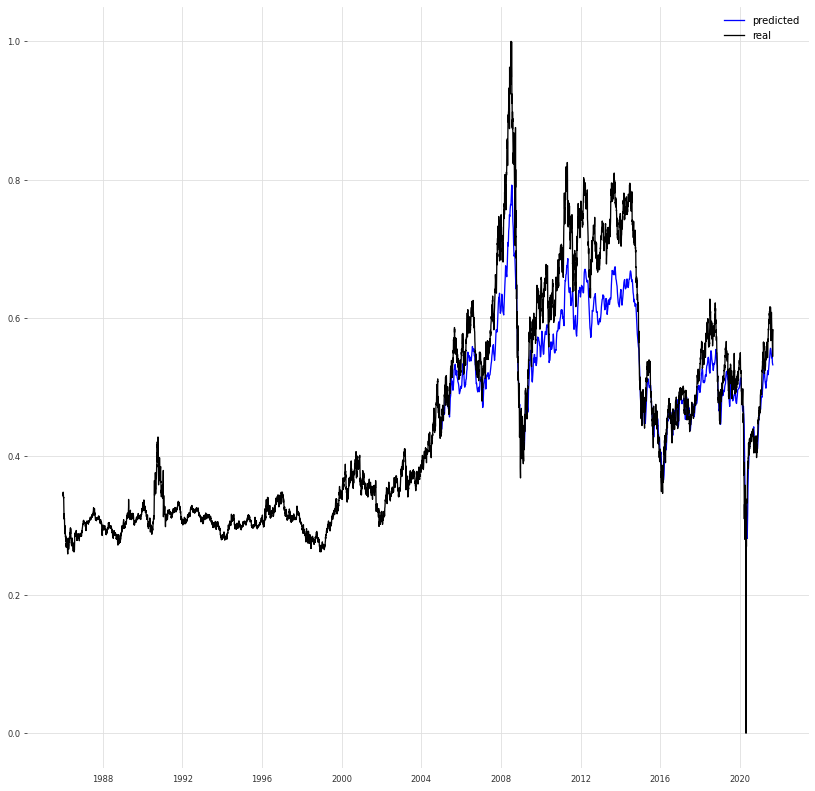

In [ ]:
plt.figure(figsize=[14,14])
plt.plot(pred_series1.pd_dataframe(),label='predicted',color='blue')
plt.plot(ts_filled.pd_dataframe(),label='real',color='black')
plt.legend()
plt.show();

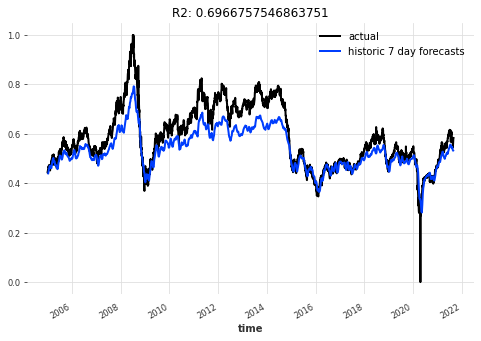

In [ ]:
display_forecast(pred_series1, ts_filled[0:], '7 day', start_date=pd.Timestamp('20050103'))

In [ ]:
k = ts_nbeats.predict(20)
k.pd_dataframe()

component,cushing
time,
2005-01-04,0.433644
2005-01-05,0.433926
2005-01-06,0.440514
2005-01-07,0.444262
2005-01-10,0.439555
2005-01-11,0.435394
2005-01-12,0.439082
2005-01-13,0.436812
2005-01-14,0.435436


In [ ]:
df_ts = ts_filled.pd_dataframe()
df_k = k.pd_dataframe()

In [ ]:
df_k.index[0]

Timestamp('2005-01-04 00:00:00', freq='B')

In [ ]:
df_ts_trunc = df_ts[df_ts.index<=dt(2005,1,4)]

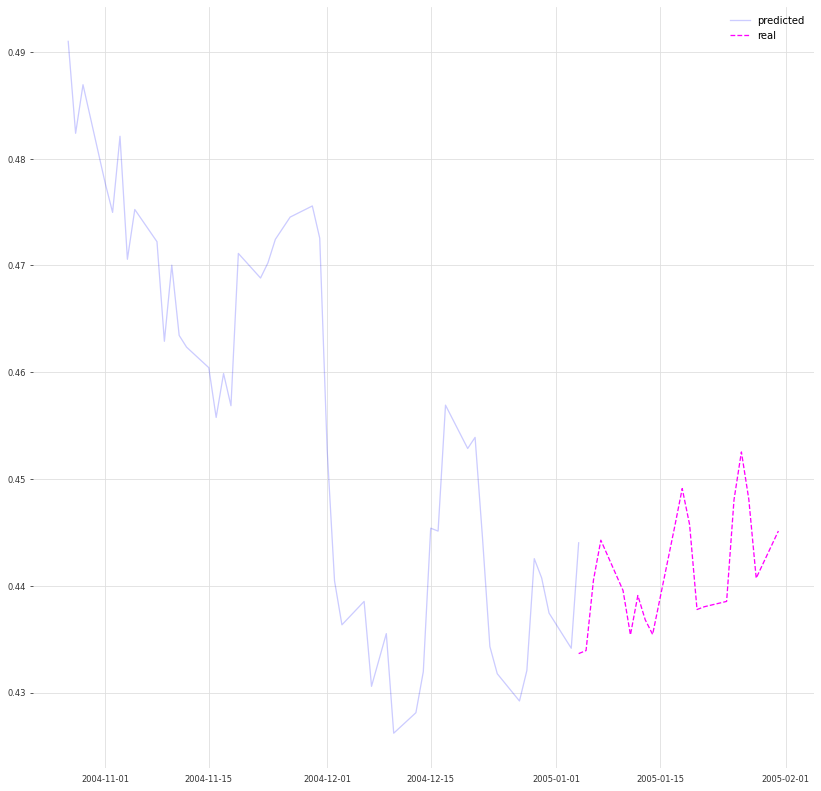

In [ ]:
plt.figure(figsize=[14,14])
plt.plot(df_ts_trunc[-50:],label='predicted',color='blue',alpha=0.2)
plt.plot(df_k,label='real',color='magenta',ls='--')
plt.legend()
plt.show();

In [ ]:
preds = ts_nbeats.predict(30,series=ts_filled[:-1])

In [ ]:
preds.pd_dataframe()

component,cushing
time,
2021-08-30,0.567369
2021-08-31,0.546438
2021-09-01,0.527903
2021-09-02,0.507652
2021-09-03,0.527616
2021-09-06,0.548622
2021-09-07,0.526740
2021-09-08,0.537313
2021-09-09,0.521129


In [ ]:
df_preds = preds.pd_dataframe()

In [ ]:
df_ts.tail()

component,cushing
Date,
2021-08-24,0.573153
2021-08-25,0.578858
2021-08-26,0.572714
2021-08-27,0.580504
2021-08-30,0.582917


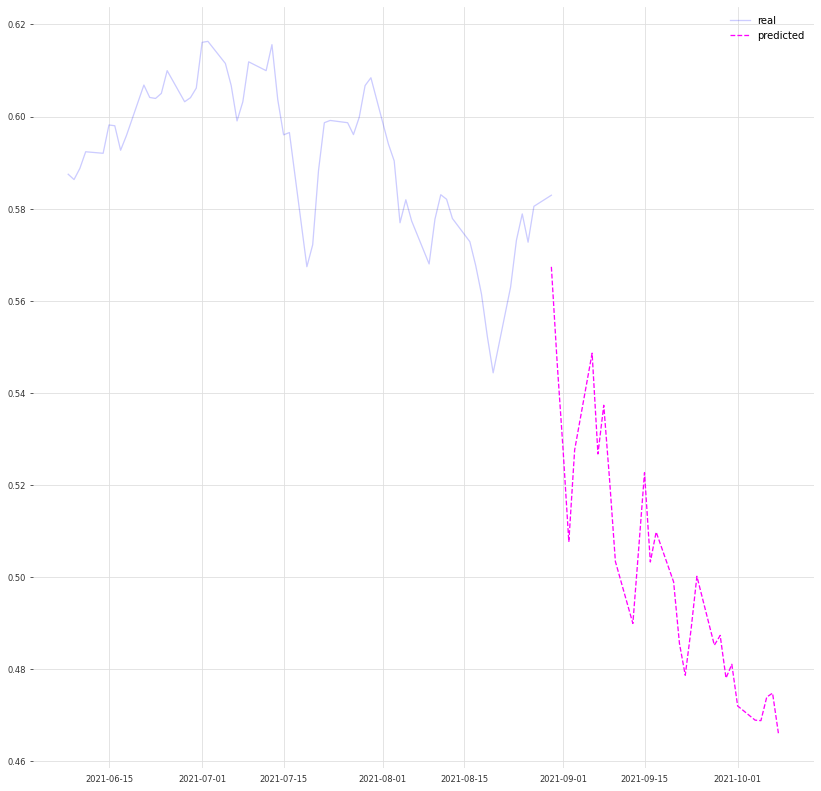

In [ ]:
plt.figure(figsize=[14,14])
plt.plot(df_ts[-60:],label='real',color='blue',alpha=0.2)
plt.plot(df_preds,label='predicted',color='magenta',ls='--')
plt.legend()
plt.show();

## Time Series forecast using other Models

In [ ]:
import numpy as np
from darts.metrics import mase
from darts.models import AutoARIMA
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis, plot_hist

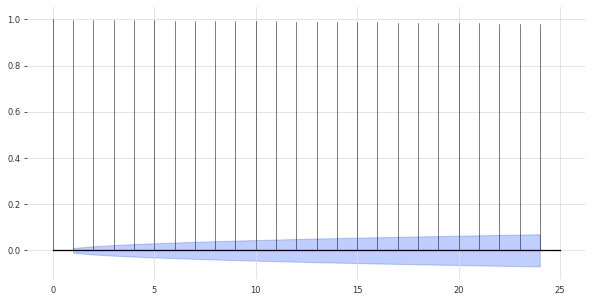

In [ ]:
plot_acf(ts_filled)

In [ ]:
check_seasonality(ts_filled)

[2021-10-07 10:52:57,570] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 24.


(False, 0)

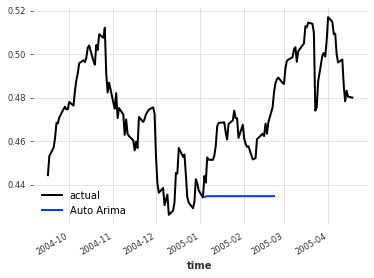

In [ ]:
autoarima_model = AutoARIMA()
autoarima_model.fit(train1)
autoarima_model_forecast = autoarima_model.predict(36)

ts_filled[4880:-4270].plot(label='actual')
autoarima_model_forecast.plot(label='Auto Arima')
plt.legend();

# Forecasting univariate using Auto ARIMA

In [ ]:
%pip install pmdarima

     |████████████████████████████████| 1.4 MB 5.0 MB/s 
     |████████████████████████████████| 9.8 MB 41.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
from pmdarima import AutoARIMA,autocorr_plot,auto_arima
from pmdarima.model_selection import train_test_split
import pmdarima as pm
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DBC.csv',parse_dates=True)
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
3923,2021-09-07,19.180000,19.260000,19.100000,19.110001,19.110001,3736200
3924,2021-09-08,19.360001,19.379999,19.200001,19.250000,19.250000,3000900
3925,2021-09-09,19.120001,19.340000,19.040001,19.110001,19.110001,1693000
3926,2021-09-10,19.389999,19.430000,19.320000,19.360001,19.360001,2815100
3927,2021-09-13,19.500000,19.540001,19.410000,19.510000,19.510000,1455700


In [ ]:
df_ts = df[['Date','Adj Close']]
df_ts.tail()

,Date,Adj Close
3923,2021-09-07,19.110001
3924,2021-09-08,19.250000
3925,2021-09-09,19.110001
3926,2021-09-10,19.360001
3927,2021-09-13,19.510000


In [ ]:
df_ts.set_index('Date',inplace=True)
df_ts.head()

,Adj Close
Date,
2006-02-06,22.048342
2006-02-07,21.410578
2006-02-08,21.319469
2006-02-09,21.519909
2006-02-10,21.128141


In [ ]:
df_res = df[['Date','Adj Close']]

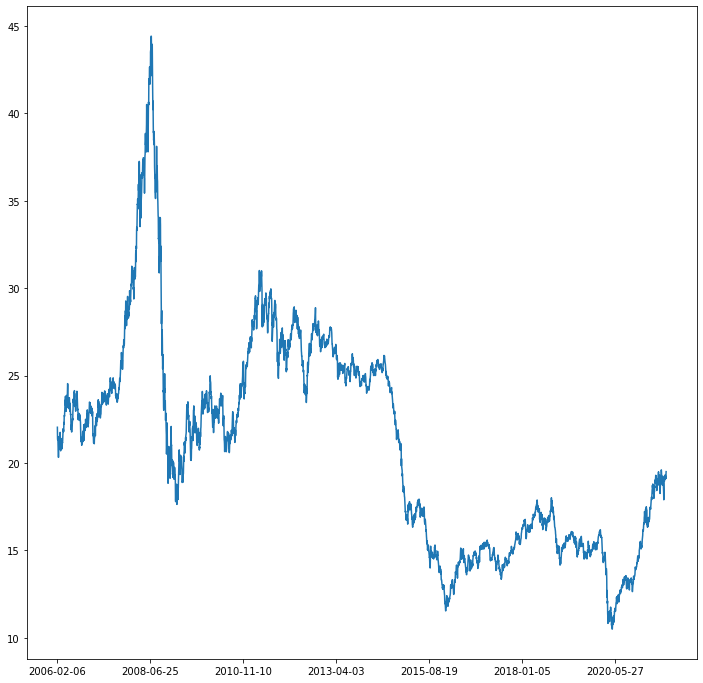

In [ ]:
plt.figure(figsize=[12,12])
plt.plot(df_res['Date'],df_res['Adj Close'])
plt.xticks(df_res.iloc[0::600,0])
plt.show()

In [ ]:
df_res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3928 entries, 0 to 3927
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3928 non-null   datetime64[ns]
 1   Adj Close  3928 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 61.5 KB


In [ ]:
df_res['Date'] = pd.to_datetime(df_res['Date'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


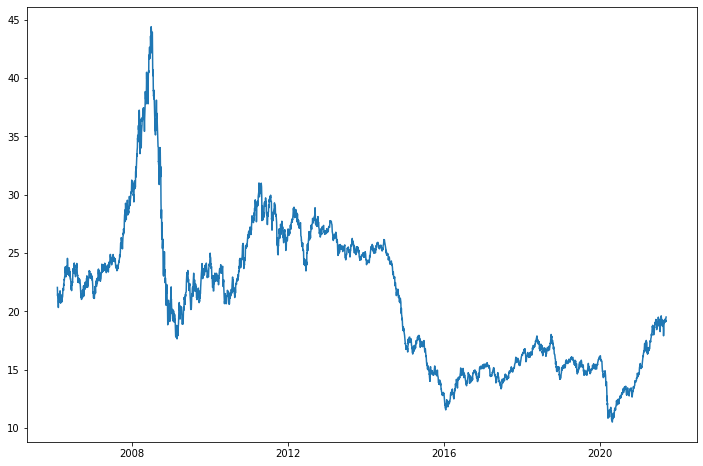

In [ ]:
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

fig,ax = plt.subplots(figsize=[12,8])
ax.plot(df_res['Date'],df_res['Adj Close'])


locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

#### change dates to index

In [ ]:
df_res.set_index('Date',inplace=True)
df_res.head()

,Adj Close
Date,
2006-02-06,22.048342
2006-02-07,21.410578
2006-02-08,21.319469
2006-02-09,21.519909
2006-02-10,21.128141


In [ ]:
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha=0.05)

In [ ]:
adf_test.should_diff(df_res)

(0.37941734589751197, True)

In [ ]:
train,test = train_test_split(df_res,test_size=0.20)
len(train),len(test)

(3142, 786)

In [ ]:
arima_model = auto_arima(train)

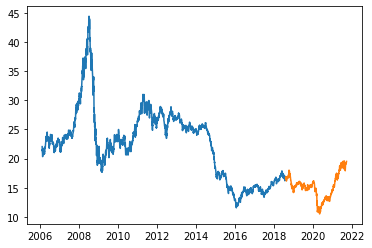

In [ ]:
plt.plot(train)
plt.plot(test)

In [ ]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3142
Model:               SARIMAX(3, 1, 1)   Log Likelihood                -702.816
Date:                Sun, 10 Oct 2021   AIC                           1415.632
Time:                        18:50:11   BIC                           1445.894
Sample:                             0   HQIC                          1426.492
                               - 3142                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9490      0.016     59.920      0.000       0.918       0.980
ar.L2         -0.0040      0.014     -0.276      0.783      -0.032       0.024
ar.L3          0.0349      0.010      3.474      0.001       0.015       0.055
ma.L1         -0.9679      0.011    -87.034      0.000      -0.990      -0.946
sigma2         0.0916      0.001     74.864      0.000       0.089       0.094
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3840.32
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.13   Skew:                            -0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
preds = pd.DataFrame(arima_model.predict(n_periods=len(test)),index = test.index)
preds.columns = ['Predicted']
preds.head()

,Predicted
Date,
2018-07-31,16.856996
2018-08-01,16.853766
2018-08-02,16.854094
2018-08-03,16.854401
2018-08-06,16.854579


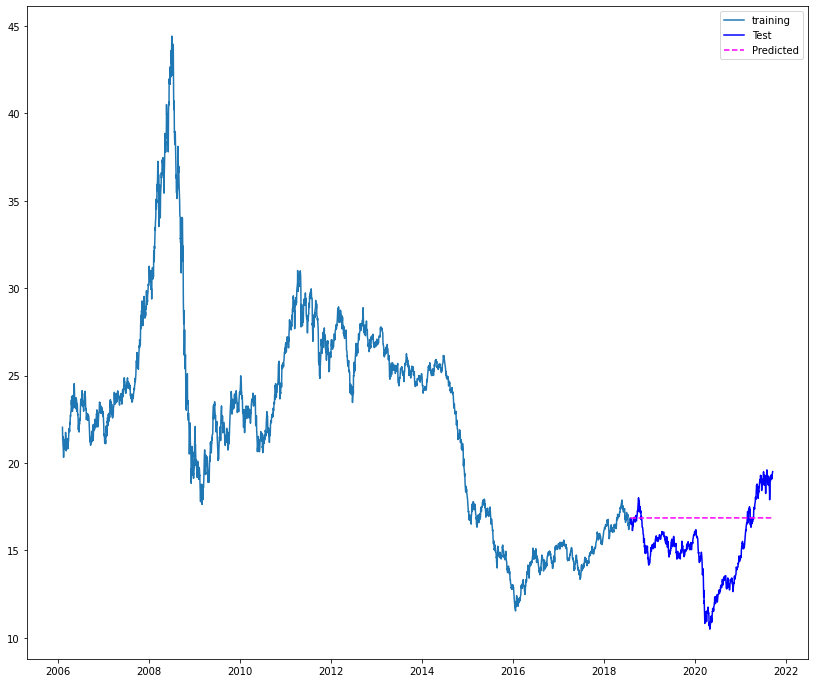

In [ ]:
plt.figure(figsize=[14,12])
plt.plot(train,label='training')
plt.plot(test,label='Test',color='blue')
plt.plot(preds,label = 'Predicted',color='magenta',ls='--')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import r2_score
r2_score(test,preds)

-0.5959616259975884